In [11]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Sample Stock Data

In [12]:
df = pd.read_csv('AAPL_sample_data.csv')

# Data Frame data types detection

In [5]:
def df_data_type_detection(df: pd.DataFrame):
    return None

In [4]:
google_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125843 entries, 0 to 125842
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           125843 non-null  object 
 1   name         125843 non-null  object 
 2   clicks       125843 non-null  int64  
 3   impressions  125843 non-null  int64  
 4   cost         125843 non-null  float64
 5   conversions  125843 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 5.8+ MB


In [4]:
df

In [6]:
df_data_type_detection(df)

# Time Series data with single variable

## Seasonality Detector

In [75]:
class SeasonalityDetector:
    def __init__(self, data, date_column=None, value_column=None):
        """
        Initialize the seasonality detector
        
        Parameters:
        - data: DataFrame with date and value columns, or Series with datetime index
        - date_column: name of date column (if DataFrame)
        - value_column: name of value column (if DataFrame)
        """
        # assign the target column value into the class instance
        if date_column:
            self.date_column = date_column
        if value_column:
            self.value_column = value_column

        # turn the data frame into a time series for futher analysis
        if isinstance(data, pd.DataFrame):
            self.df = data.copy()
            if date_column:
                self.df[date_column] = pd.to_datetime(self.df[date_column])
                self.df = self.df.sort_values(date_column).reset_index(drop = True)
                self.df.set_index(date_column, inplace=True)
            self.ts = self.df[value_column] if value_column else self.df.iloc[:, 0]
        else:
            self.ts = data.copy()
            self.df = pd.DataFrame({'value': data})
        
        # Ensure datetime index
        if not isinstance(self.ts.index, pd.DatetimeIndex):
            raise ValueError("Index must be datetime")
            
        # Spread to weekly and yearly data
        self.daily, self.weekly, self.monthly, self.yearly = self.daily_to_weekly_and_yearly(date_col=date_column, value_col=value_column, method='sum', week_start='Sunday')
            
    def basic_statistics(self):
        """Calculate basic statistics"""
        print("=== BASIC STATISTICS ===")
        print(f"Period: {self.ts.index.min()} to {self.ts.index.max()}")
        print(f"Total observations: {len(self.ts)}")
        print(f"Mean: {self.ts.mean():.4f}")
        print(f"Std: {self.ts.std():.4f}")
        print(f"Min: {self.ts.min():.4f}")
        print(f"Max: {self.ts.max():.4f}")
        print(f"Missing values: {self.ts.isna().sum()}")
        
    def visual_inspection(self):
        """Create visualizations for pattern detection"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series plot
        axes[0,0].plot(self.monthly.index, self.monthly.values)
        axes[0,0].set_title('Time Series')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel(f'{self.value_column}')
        
        # Monthly boxplot
        axes[0,1].boxplot(x = self.monthly.values)
        axes[0,1].set_title('Monthly Seasonality')
        axes[0,1].set_ylabel(f'{self.value_column}')
        
        # Day of week boxplot
        axes[1,0].boxplot(self.weekly.values)
        axes[1,0].set_title('Day of Week Seasonality')
        axes[1,0].set_xlabel('Day of Week')
        axes[1,0].set_ylabel(f'{self.value_column}')
        
        # Histogram
        axes[1,1].hist(self.ts.values, bins=30, alpha=0.7)
        axes[1,1].set_title('Distribution')
        axes[1,1].set_xlabel(f'{self.value_column}')
        axes[1,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    def daily_to_weekly_and_yearly(self, date_col=None, value_col=None, method='mean', week_start='Monday'):
        """
        Convert daily data to weekly and yearly data

        args:
            date_col: str, name of date column (if DataFrame)
            value_col: str, name of value column (if DataFrame)
            method: str, aggregation method ('mean', 'sum', 'median', 'min', 'max', 'std', 'count')
            week_start: str, 'Monday' or 'Sunday'

        Returns:
            
        """
        # Set week start
        if week_start == 'Sunday':
            freq_weekly = 'W-SUN'
        else:
            freq_weekly = 'W-MON'  # Default is Monday

        freq_yearly = 'YS'  # Year start frequency
        freq_monthly = 'MS' # Month start frequency
        freq_daily = 'D'

        # Aggregate based on method
        def aggregate_data(ts, freq, method):
            if method == 'mean':
                return ts.resample(freq).mean()
            elif method == 'sum':
                return ts.resample(freq).sum()
            elif method == 'median':
                return ts.resample(freq).median()
            elif method == 'min':
                return ts.resample(freq).min()
            elif method == 'max':
                return ts.resample(freq).max()
            elif method == 'std':
                return ts.resample(freq).std()
            elif method == 'count':
                return ts.resample(freq).count()
            else:
                raise ValueError(f"Unknown method: {method}")

        # Generate weekly and yearly data
        daily_data = aggregate_data(self.ts, freq_daily, method)
        weekly_data = aggregate_data(self.ts, freq_weekly, method)
        monthly_data = aggregate_data(self.ts, freq_monthly, method)
        yearly_data = aggregate_data(self.ts, freq_yearly, method)

        return daily_data, weekly_data, monthly_data, yearly_data

    
    def autocorrelation_analysis(self, 
                                 segments:str = 'daily'):
        """
        Analyze autocorrelation patterns
        
        args:
            segments: str, segments for determine the correlation, limited to daily, weekly
        returns:
            None
        
        """
        print("\n=== AUTOCORRELATION ANALYSIS ===")
        
        # Plot ACF and PACF
        fig, axes = plt.subplots(2, 1, figsize=(15, 8))
        
        # based on the segments to check the lags
        if segments == 'daily':
            ts = self.ts
        elif segments == 'weekly':
            ts = self.weekly
        else:
            print(f"'{segments}' is not a suitable segment!")
        
        
        # default lags
        lags = 50
        # ensure there's enough lags for look back
        if len(ts) < lags:
            lags = len(ts) - 1
        
        plot_acf(ts.dropna(), lags=lags, ax=axes[0], title='Autocorrelation Function')
        axes[0].set_xlabel('Lags')
        plot_pacf(ts.dropna(), lags=lags/2, ax=axes[1], title='Partial Autocorrelation Function')
        axes[1].set_xlabel('Lags')
        
        plt.tight_layout()
        plt.show()
        
        print("\n=== Overall correlation in daily ===")
        # Calculate specific lag correlations
        lags_to_check = [7, 30, 90, 180, 365]  # Weekly, monthly, quarterly, semi-annual, annual
        
        for lag in lags_to_check:
            if len(self.ts) > lag:
                correlation = self.ts.autocorr(lag=lag)
                print(f"Lag {lag} autocorrelation: {correlation:.4f}")
        return None
    
    def seasonal_decomposition(self, model='additive', period=365):
        """Perform seasonal decomposition"""
        print(f"\n=== SEASONAL DECOMPOSITION (Period: {period}) ===")
        
        try:
            decomposition = seasonal_decompose(self.ts.dropna(), 
                                             model=model, 
                                             period=period)
            
            # Plot decomposition
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            
            decomposition.observed.plot(ax=axes[0], title='Original')
            decomposition.trend.plot(ax=axes[1], title='Trend')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition.resid.plot(ax=axes[3], title='Residual')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate seasonal strength
            seasonal_strength = np.var(decomposition.seasonal) / np.var(decomposition.resid + decomposition.seasonal)
            print(f"Seasonal Strength: {seasonal_strength:.4f}")
            
            return decomposition
            
        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
            return None

In [76]:
# instance creation
stock_ssd = SeasonalityDetector(df, date_column = 'date', value_column = 'close_p')

### Basic statistics on the time series data

In [71]:
# simple statistics
stock_ssd.basic_statistics()

=== BASIC STATISTICS ===
Period: 2023-02-16 00:00:00 to 2025-07-15 00:00:00
Total observations: 641
Mean: 198.4562
Std: 25.0922
Min: 145.3100
Max: 259.0200
Missing values: 0


### Simple data visualization

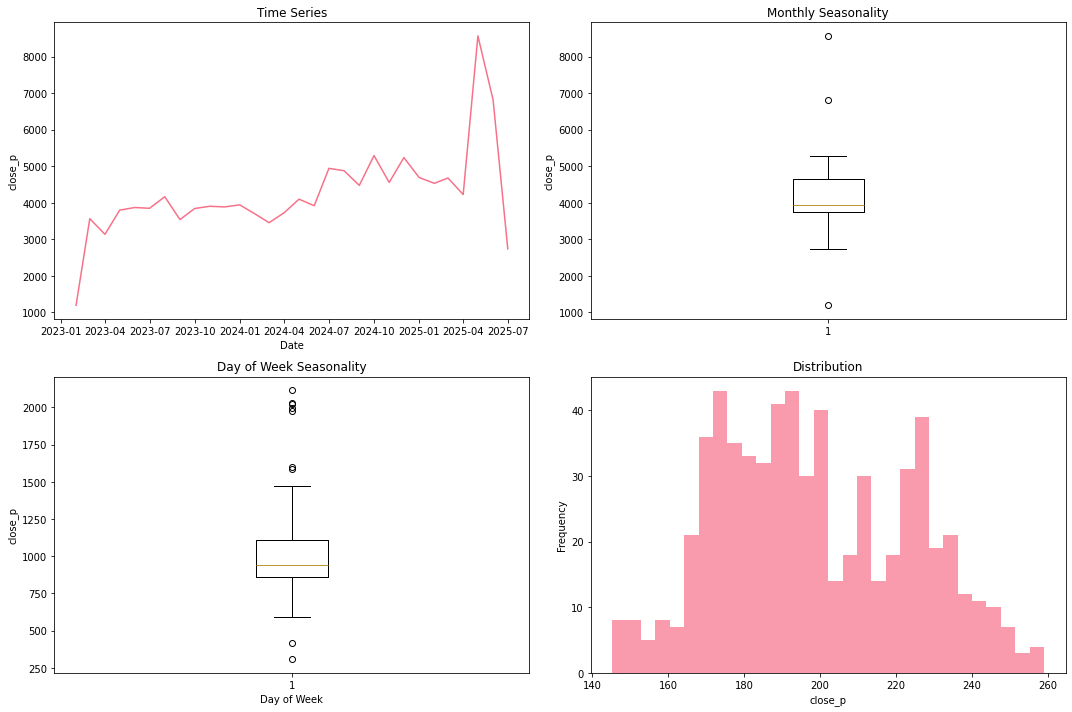

In [72]:
# look into the trend, monthly, daily outliers and the data distributions
stock_ssd.visual_inspection()

### Auto-correlation (ACF & PACF)

- ACF: Properly check the stability or if there's any exponential decay, all lags are in the confidence interval -> White noise.

- PACF: Detect the order of auto-regressions, pay attention to the lag out of the confidence interval, those lags within the interval assuming there's no effect.


=== AUTOCORRELATION ANALYSIS ===


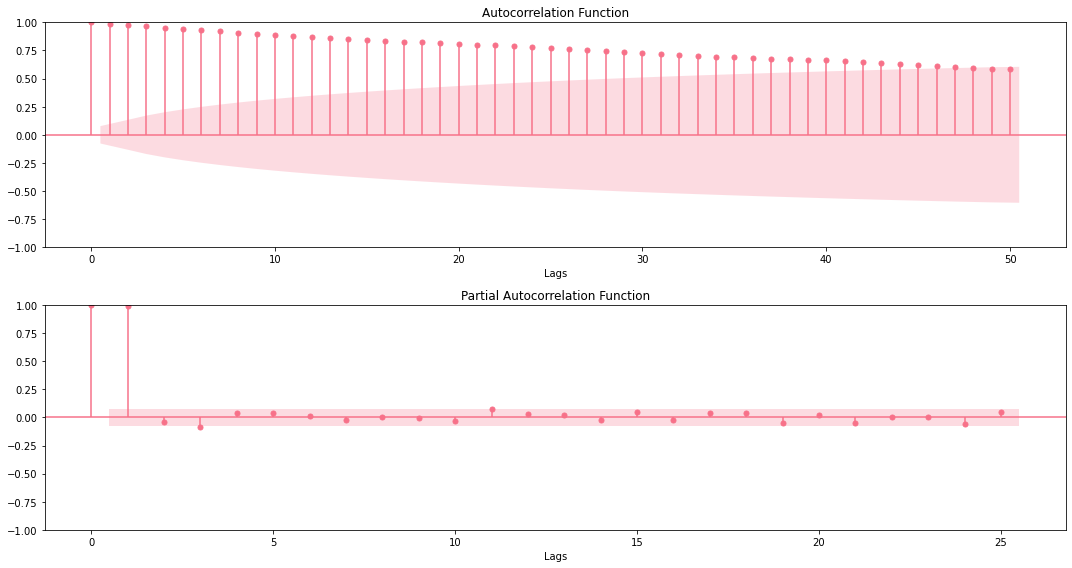


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.9407
Lag 30 autocorrelation: 0.7945
Lag 90 autocorrelation: 0.4352
Lag 180 autocorrelation: 0.0038
Lag 365 autocorrelation: -0.0357


In [73]:
stock_ssd.autocorrelation_analysis('daily')

### Seasonal decomposition

There must be at least 2 years data.

In [80]:
stock_ssd.seasonal_decomposition()


=== SEASONAL DECOMPOSITION (Period: 365) ===
Error in seasonal decomposition: x must have 2 complete cycles requires 730 observations. x only has 641 observation(s)
